In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal 
import scipy.stats as stats
import tqdm

In [2]:
plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['font.serif'] = []
plt.rcParams['text.usetex'] = False
#plt.rcParams['figure.figsize'] = 3.5, 2.625
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['errorbar.capsize'] = 2
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] = 12
#plt.rcParams['legend.frameon'] = False

In [24]:
generate_data = True
directory = "/hpcwork/zu992399/look_elsewhere/NP_test/"

bins = 5
bins_edge = 10
N = 10000
N_tests = 10000

# Generate Data

In [22]:
def draw_data(N_data= 10000, mu=[0,0], sigma=[[1,0],[0,1]]):
    rv = multivariate_normal(mu, sigma)
    return  rv.rvs(mu, sigma, size=N_data), rv

def get_p_value(sig):
    return 2*(1-stats.norm.cdf(sig))

def p_value_poissonpoisson_2tailed(N_data, N_BT, k=0.5):
    p_value = 1-stats.nbinom.cdf(N_data-1, N_BT, k)
    p_left = stats.nbinom.cdf(N_data, N_BT, 0.5)
    return np.min(np.array([p_value, p_left]), axis=0)*2

def p_value_poissonpoisson(N_data, N_BT, k=0.5):
    return 1-stats.nbinom.cdf(N_data-1, N_BT, k)

def p_value_binomial(N_data, N_BT, N_total):
    p_value = 1-stats.binom.cdf(N_data-1, N_total, N_BT/N_total)
    p_left = stats.binom.cdf(N_data, N_total, N_BT/N_total) 
    return np.min(np.array([p_value, p_left]), axis=0)*2
    #return p_value

In [9]:
BH_percentiles = [1e-1, 1e-2, 1e-3, 1e-4]
fixed_cut = [0.51, 0.53, 0.55]

def calc_and_apply_threshold(samples_preds, data_preds, efficiency):
    """
    Returns number of samples and data events before and after cut

    Apply quantile cut based on efficiency to samples classifier scores and then the
    same threshold to data classifier scores 
    """
    eps = np.quantile(samples_preds, 1-efficiency, method="nearest")
    if efficiency == 1:
        eps=0.
    N_samples_after = np.size(np.where(samples_preds>eps))
    N_samples = len(samples_preds)
    N_after = np.size(np.where(data_preds>eps))
    N = len(data_preds)
    return N_samples_after, N_samples, N_after, N

class classifier():
    def __init__(self, bin_edges, data_binned, BT_binned):
        self.edges = bin_edges
        with np.errstate(divide='ignore', invalid='ignore'):
            eps = 1e-20
            self.scores = (data_binned + eps) / np.sum(data_binned) / (BT_binned + eps) * np.sum(BT_binned)
        #self.scores = self.scores/(1+self.scores)
        #self.scores[(data_binned==0) & (BT_binned==0)] = 1
        #self.scores[(data_binned==0) & (BT_binned!=0)] = 0
        #self.scores[(BT_binned==0) & (data_binned!=0)] = 10000
        #print(sum((data_binned==0)), sum((BT_binned==0)))
        
    def find_bins(self, data):
        # Find the bin index for x and y
        x_bin = np.searchsorted(self.edges[0], data[:,0], side='right') - 1
        y_bin = np.searchsorted(self.edges[1], data[:,1], side='right') - 1

        #x_bin[(x_bin<0) | (x_bin>=len(self.edges[0])-1)]
        #x_bin[(y_bin<0) | (y_bin>=len(self.edges[1])-1)]

        return x_bin, y_bin

    def predict(self, data):
        locs = self.find_bins(data)
        scores = self.scores[locs[0], locs[1]]
        scores[locs[0]==-1]=-1
        scores[locs[1]==-1]=-1
        return scores

def p_values_from_folder(data_tuple, save_folder, save_file, remove_0s=True):
    N_samples_after = data_tuple[0]
    N_samples = data_tuple[1]
    N_after = data_tuple[2]
    N = data_tuple[3]
    p = []
    for i in range(len(N[0])):
        if remove_0s:
            inds = np.nonzero(N_samples_after[:,i])[0]
            inds2 = np.nonzero(N_after[inds,i])[0]
            p.append(np.sort(p_value_poissonpoisson(N_after[inds,i][inds2], N_samples_after[inds,i][inds2]/N_samples[inds,i][inds2]*N[inds,i][inds2])))
        else: 
            p.append(np.sort(p_value_poissonpoisson(N_after[:,i], N_samples_after[:,i]/N_samples[:,i]*N[:,i])))
    np.save(save_folder+save_file, np.array(p))

def oned_sample(N, rv):
    x = rv.rvs(N).reshape((N,1))
    y = rv.rvs(N).reshape((N,1))
    return np.concatenate((x,y), axis=1)

In [25]:
if generate_data:
    def do_test_val(N_tests, bins, N, name, bins_edge = None, uniform=True):
        rv = multivariate_normal([0,0], [[1,0],[0,1]])        
        if bins_edge is None:
            edges = np.histogramdd(rv.rvs(size=100000), bins=bins)[1]
        else:
            edges = [np.linspace(-bins_edge,bins_edge,bins+1), np.linspace(-bins_edge,bins_edge,bins+1)]

        if uniform: 
            rv = stats.uniform(loc=-bins_edge, scale=2*bins_edge)

        arr_shape = (N_tests,len(BH_percentiles))
        N_samples_after_train = np.zeros(arr_shape)
        N_samples_train = np.zeros(arr_shape)
        N_after_train = np.zeros(arr_shape)
        N_train = np.zeros(arr_shape)

        N_samples_after_test = np.zeros(arr_shape)
        N_samples_test = np.zeros(arr_shape)
        N_after_test = np.zeros(arr_shape)
        N_test = np.zeros(arr_shape)

        for k in tqdm.tqdm(range(N_tests)):
            if uniform: 
                data_train = oned_sample(N, rv)
                BT_train = oned_sample(N, rv)  
            else:
                data_train = rv.rvs(size=N, random_state=k)
                BT_train = rv.rvs(size=N, random_state=k+N_tests)
            
            data_binned = np.histogramdd(data_train, bins=edges)[0]
            BT_binned = np.histogramdd(BT_train, bins=edges)[0]
            model = classifier(edges, data_binned, BT_binned)

            if uniform:
                data_test = oned_sample(N, rv)
                BT_test = oned_sample(N, rv)
            else:  
                data_test = rv.rvs(size=N, random_state=k+2*N_tests)
                BT_test = rv.rvs(size=N, random_state=k+3*N_tests)
            for j, perc in enumerate(BH_percentiles):
                N_samples_after_train[k,j], N_samples_train[k,j], N_after_train[k,j], N_train[k,j] = calc_and_apply_threshold(model.predict(BT_train), model.predict(data_train), perc)
                N_samples_after_test[k,j], N_samples_test[k,j], N_after_test[k,j], N_test[k,j] = calc_and_apply_threshold(model.predict(BT_test), model.predict(data_test), perc)

        p_values_from_folder((N_samples_after_train, N_samples_train, N_after_train, N_train), directory+name+"/", "p_train.npy")
        p_values_from_folder((N_samples_after_test, N_samples_test, N_after_test, N_test), directory+name+"/", "p_test.npy")

    do_test_val(N_tests, 5, N, "bins_5", bins_edge=bins_edge)
    do_test_val(N_tests, 25, N, "bins_25", bins_edge=bins_edge)
    do_test_val(N_tests, 100, N, "bins_100", bins_edge=bins_edge)

100%|██████████| 10000/10000 [01:14<00:00, 134.87it/s]
/tmp/zu992399/login23-3_1228162/ipykernel_1929820/44212084.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(save_folder+save_file, np.array(p))
100%|██████████| 10000/10000 [02:47<00:00, 59.71it/s]
/home/zu992399/.local/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:336: RuntimeWarning: divide by zero encountered in _nbinom_cdf
  return _boost._nbinom_cdf(k, n, p)


In [32]:
if generate_data:
    def do_test_kfold(N_tests, bins, N, name, bins_edge = None, uniform=True, folds=5):
        print(N)
        rv = multivariate_normal([0,0], [[1,0],[0,1]])        
        if bins_edge is None:
            edges = np.histogramdd(rv.rvs(size=100000), bins=bins)[1]
        else:
            edges = [np.linspace(-bins_edge,bins_edge,bins+1), np.linspace(-bins_edge,bins_edge,bins+1)]

        if uniform: 
            rv = stats.uniform(loc=-bins_edge, scale=2*bins_edge)
        arr_shape = (folds, N_tests,len(BH_percentiles))

        N_samples_after_test = np.zeros(arr_shape)
        N_samples_test = np.zeros(arr_shape)
        N_after_test = np.zeros(arr_shape)
        N_test = np.zeros(arr_shape)

        for k in tqdm.tqdm(range(N_tests)):
            if uniform: 
                data = oned_sample(N, rv)
                BT = oned_sample(N, rv)  
            else:
                data = rv.rvs(size=N, random_state=k)
                BT = rv.rvs(size=N, random_state=k+N_tests)
            data = np.array_split(data, folds)
            BT = np.array_split(BT, folds)

            data_hist = np.zeros((bins,bins, folds))
            BT_hist = np.zeros((bins,bins, folds))
            for m in range(folds):
                data_hist[:,:,m] = np.histogramdd(data[m], bins=edges)[0]
                BT_hist[:,:,m] = np.histogramdd(BT[m], bins=edges)[0]

            for fold in range(folds):
                inds = np.roll(np.array(range(folds)), fold)
                model = classifier(edges, np.sum(data_hist[:,:,:-1],axis=-1), np.sum(BT_hist[:,:,:-1],axis=-1))

                for j, perc in enumerate(BH_percentiles):
                    N_samples_after_test[fold, k,j], N_samples_test[fold, k,j], N_after_test[fold, k,j], N_test[fold, k,j] = calc_and_apply_threshold(model.predict(BT[inds[-1]]), model.predict(data[inds[-1]]), perc)
        
        
        
        #p_values_from_folder((N_samples_after_train, N_samples_train, N_after_train, N_train), directory, "p_train.npy")
        p_values_from_folder((np.sum(N_samples_after_test, axis=0),np.sum(N_samples_test, axis=0), np.sum(N_after_test,axis=0), np.sum(N_test,axis=0)), directory+name+"/", "p_kfold.npy")

    do_test_kfold(N_tests, 5, N, "bins_5", bins_edge=bins_edge)
    do_test_kfold(N_tests, 25, N, "bins_25", bins_edge=bins_edge)
    do_test_kfold(N_tests, 100, N, "bins_100", bins_edge=bins_edge)


10000


100%|██████████| 10000/10000 [00:53<00:00, 186.23it/s]
/tmp/zu992399/login23-3_1228162/ipykernel_1929820/44212084.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(save_folder+save_file, np.array(p))


10000


100%|██████████| 10000/10000 [01:22<00:00, 121.12it/s]


10000


100%|██████████| 10000/10000 [02:03<00:00, 81.19it/s]
/home/zu992399/.local/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:336: RuntimeWarning: divide by zero encountered in _nbinom_cdf
  return _boost._nbinom_cdf(k, n, p)


# Plot results

In [12]:
colors=["green", "blue", "red"]#, "orange"]
labels=[r"$10^{-1}$",r"$10^{-2}$"]#, r"$10^{-4}$"]
def plot_array(ax, p_values):
    for i in range(len(labels)):
        ax.plot(np.arange(1, len(p_values[i])+1)/len(p_values[i]), p_values[i], colors[i], label=labels[i])

def plot_histogram(ax, p_values, bins):
    for i in range(len(labels)):
        y, _, _ = ax.hist(p_values[i], bins=bins, histtype="step", color=colors[i], label=labels[i], density=True)

/home/zu992399/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


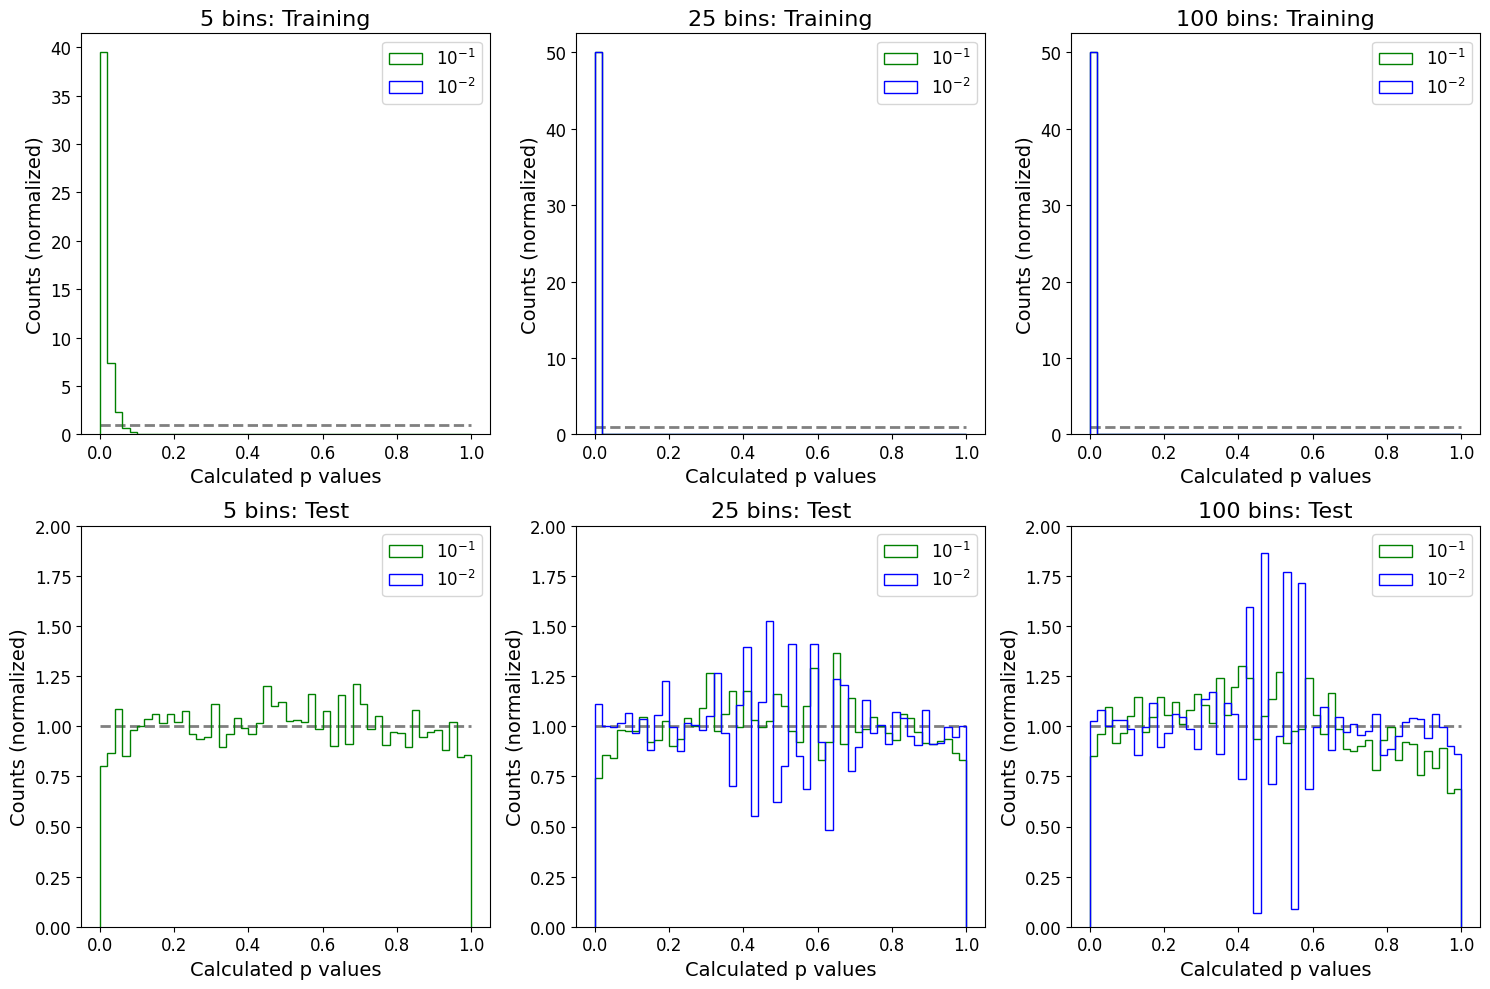

In [27]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()
bins_plot=np.linspace(0,1,51)
bins_center = 0.5*(bins_plot[1:]+bins_plot[:-1])

p_train_5 = np.load(directory+"bins_5/"+"p_train.npy",allow_pickle=True)
p_test_5 = np.load(directory+"bins_5/"+"p_test.npy",allow_pickle=True)

p_train_25 = np.load(directory+"bins_25/"+"p_train.npy",allow_pickle=True)
p_test_25 = np.load(directory+"bins_25/"+"p_test.npy",allow_pickle=True)

p_train_100 = np.load(directory+"bins_100/"+"p_train.npy",allow_pickle=True)
p_test_100 = np.load(directory+"bins_100/"+"p_test.npy",allow_pickle=True)

for i in range(len(ax)):
    ax[i].set_xlabel("Calculated p values")
    ax[i].set_ylabel("Counts (normalized)")
    ax[i].plot([0,1],[1,1], linestyle="dashed", color="grey")


plot_histogram(ax[0], p_train_5, bins_plot)
#y, _, _ = ax[0].hist(p_train_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
#ax[0].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[0].set_title("5 bins: Training")
ax[0].legend(loc="upper right")

plot_histogram(ax[3], p_test_5, bins_plot)
#y,_, _ = ax[1].hist(p_values_test, bins=bins_plot, histtype="step", color="black", density=True)
#ax[1].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[3].set_title("5 bins: Test")
ax[3].set_ylim(0,2)
ax[3].legend(loc="upper right")

plot_histogram(ax[1], p_train_25, bins_plot)
#y, _, _ = ax[0].hist(p_train_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
#ax[0].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[1].set_title("25 bins: Training")
ax[1].legend(loc="upper right")

plot_histogram(ax[4], p_test_25, bins_plot)
#y,_, _ = ax[1].hist(p_values_test, bins=bins_plot, histtype="step", color="black", density=True)
#ax[1].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[4].set_title("25 bins: Test")
ax[4].set_ylim(0,2)
ax[4].legend(loc="upper right")

plot_histogram(ax[2], p_train_100, bins_plot)
#y, _, _ = ax[0].hist(p_train_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
#ax[0].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[2].set_title("100 bins: Training")
ax[2].legend(loc="upper right")

plot_histogram(ax[5], p_test_100, bins_plot)
#y,_, _ = ax[1].hist(p_values_test, bins=bins_plot, histtype="step", color="black", density=True)
#ax[1].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[5].set_title("100 bins: Test")
ax[5].set_ylim(0,2)
ax[5].legend(loc="upper right")

fig.tight_layout()
fig.savefig("plots/NP_histograms.pdf")

/home/zu992399/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


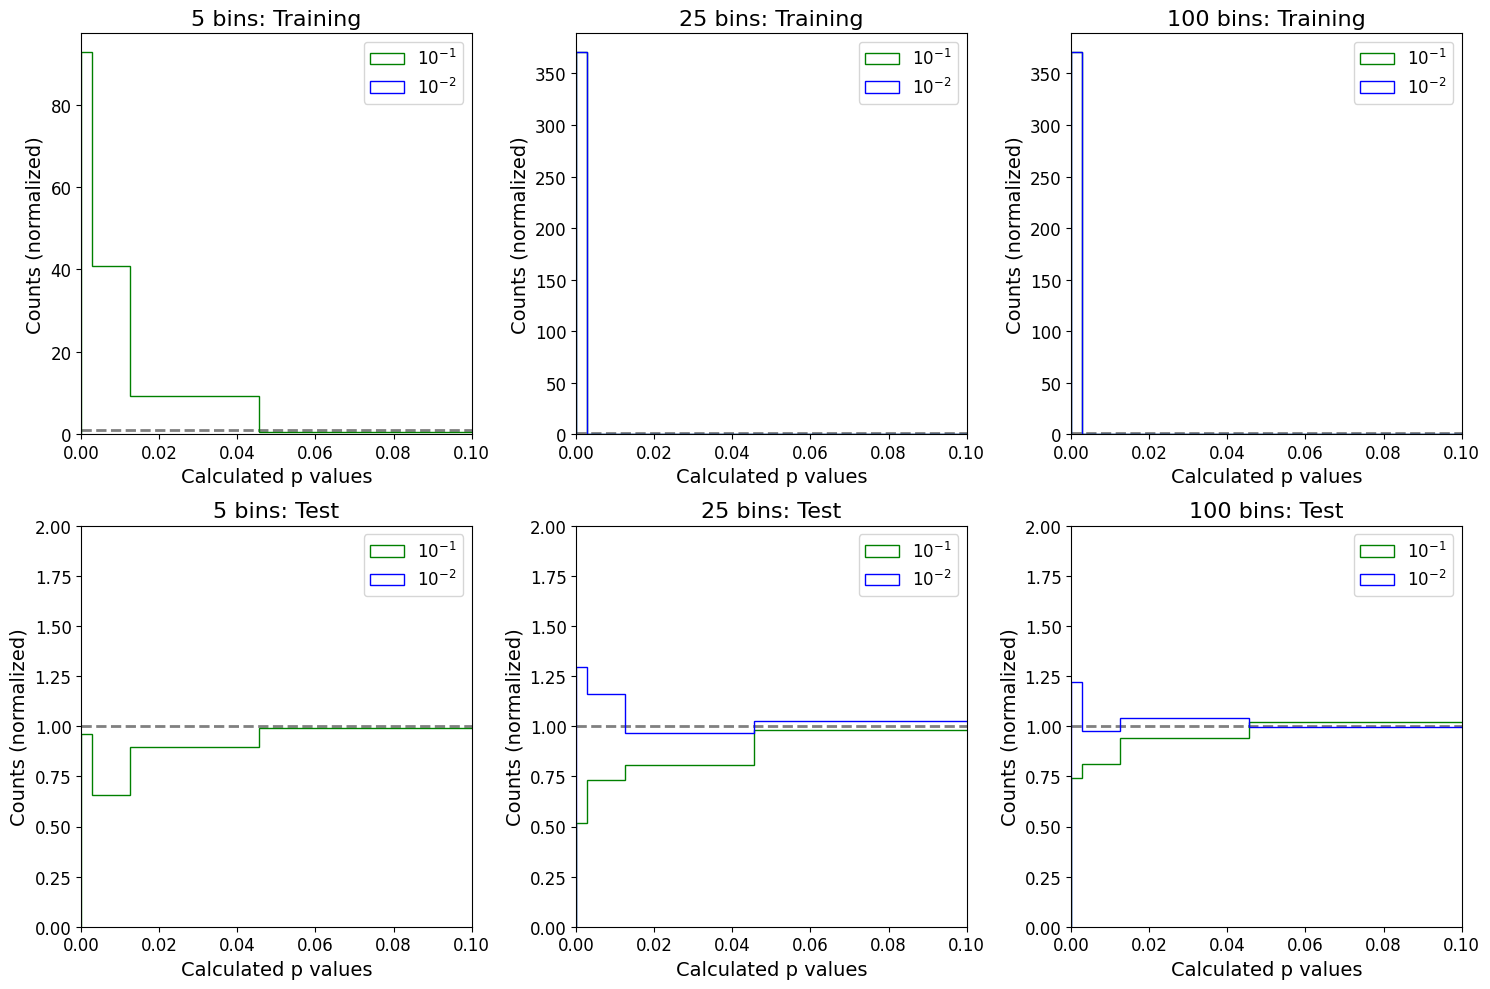

In [28]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()
bins_plot=[0, 2-2*stats.norm.cdf(3), 2-2*stats.norm.cdf(2.5), 2-2*stats.norm.cdf(2), 2-2*stats.norm.cdf(1.5), 2-2*stats.norm.cdf(1), 1]

p_train_5 = np.load(directory+"bins_5/"+"p_train.npy",allow_pickle=True)
p_test_5 = np.load(directory+"bins_5/"+"p_test.npy",allow_pickle=True)

p_train_25 = np.load(directory+"bins_25/"+"p_train.npy",allow_pickle=True)
p_test_25 = np.load(directory+"bins_25/"+"p_test.npy",allow_pickle=True)

p_train_100 = np.load(directory+"bins_100/"+"p_train.npy",allow_pickle=True)
p_test_100 = np.load(directory+"bins_100/"+"p_test.npy",allow_pickle=True)

for i in range(len(ax)):
    ax[i].set_xlabel("Calculated p values")
    ax[i].set_ylabel("Counts (normalized)")
    ax[i].plot([0,1],[1,1], linestyle="dashed", color="grey")


plot_histogram(ax[0], p_train_5, bins_plot)
#y, _, _ = ax[0].hist(p_train_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
#ax[0].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[0].set_title("5 bins: Training")
ax[0].legend(loc="upper right")

plot_histogram(ax[3], p_test_5, bins_plot)
#y,_, _ = ax[1].hist(p_values_test, bins=bins_plot, histtype="step", color="black", density=True)
#ax[1].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[3].set_title("5 bins: Test")
ax[3].set_ylim(0,2)
ax[3].legend(loc="upper right")

plot_histogram(ax[1], p_train_25, bins_plot)
#y, _, _ = ax[0].hist(p_train_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
#ax[0].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[1].set_title("25 bins: Training")
ax[1].legend(loc="upper right")

plot_histogram(ax[4], p_test_25, bins_plot)
#y,_, _ = ax[1].hist(p_values_test, bins=bins_plot, histtype="step", color="black", density=True)
#ax[1].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[4].set_title("25 bins: Test")
ax[4].set_ylim(0,2)
ax[4].legend(loc="upper right")

plot_histogram(ax[2], p_train_100, bins_plot)
#y, _, _ = ax[0].hist(p_train_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
#ax[0].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[2].set_title("100 bins: Training")
ax[2].legend(loc="upper right")

plot_histogram(ax[5], p_test_100, bins_plot)
#y,_, _ = ax[1].hist(p_values_test, bins=bins_plot, histtype="step", color="black", density=True)
#ax[1].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[5].set_title("100 bins: Test")
ax[5].set_ylim(0,2)
ax[5].legend(loc="upper right")


for i in range(len(ax)):
    ax[i].set_xlim(0,0.1)

fig.tight_layout()
fig.savefig("plots/NP_histograms_sigmas.pdf")

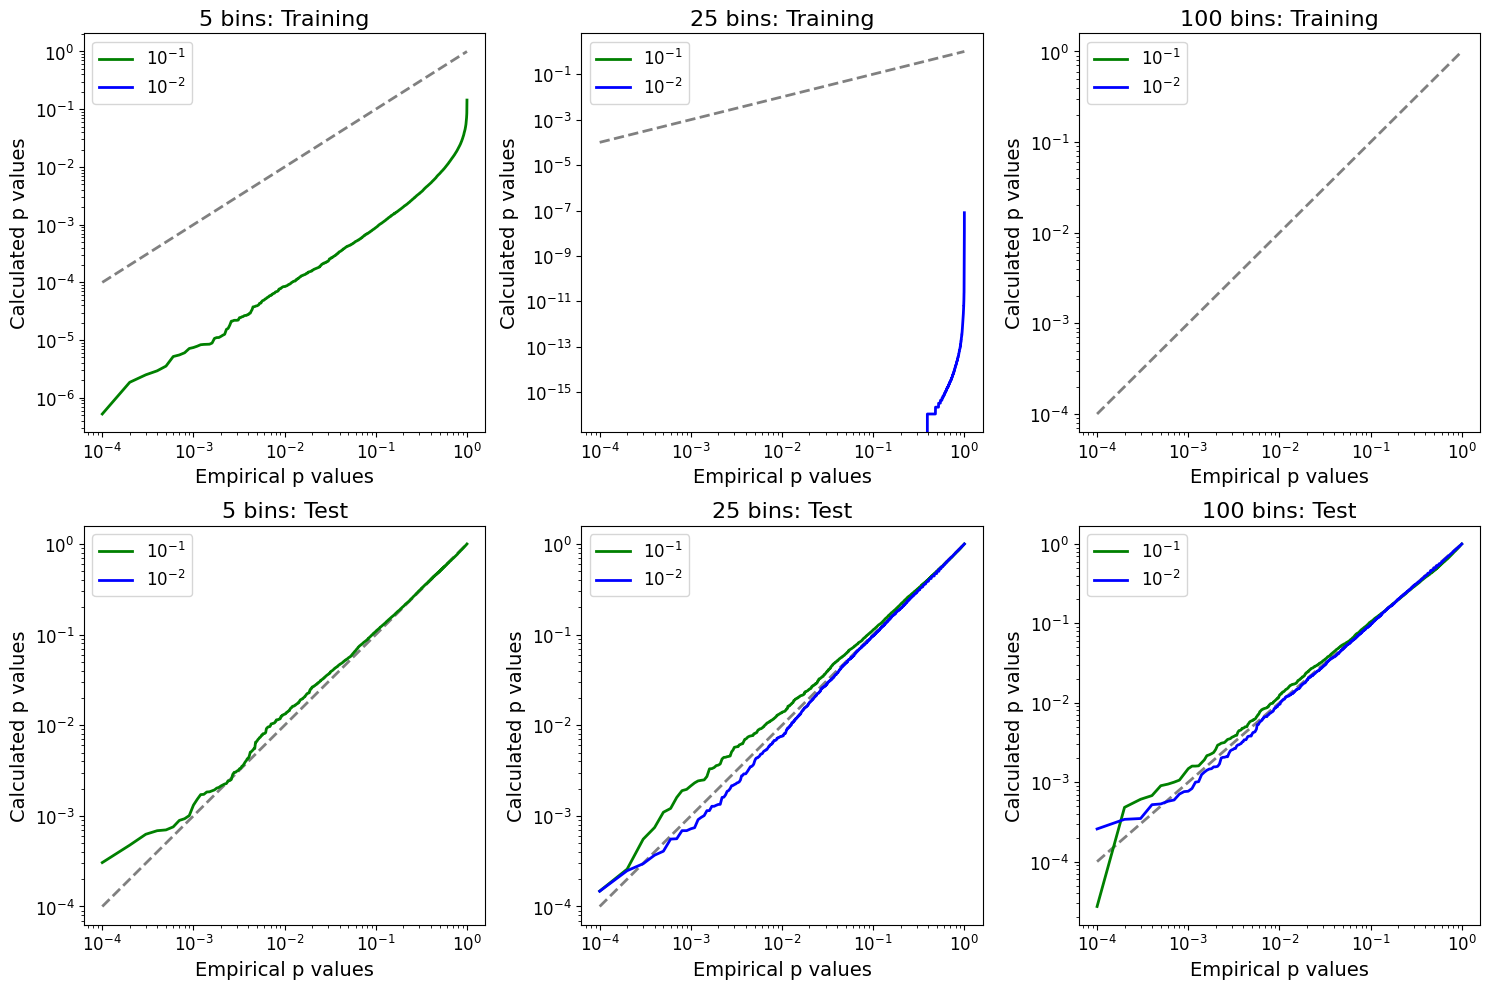

In [31]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()

p_train_5 = np.load(directory+"bins_5/"+"p_train.npy",allow_pickle=True)
p_test_5 = np.load(directory+"bins_5/"+"p_test.npy",allow_pickle=True)

p_train_25 = np.load(directory+"bins_25/"+"p_train.npy",allow_pickle=True)
p_test_25 = np.load(directory+"bins_25/"+"p_test.npy",allow_pickle=True)

p_train_100 = np.load(directory+"bins_100/"+"p_train.npy",allow_pickle=True)
p_test_100 = np.load(directory+"bins_100/"+"p_test.npy",allow_pickle=True)


for i in range(len(ax)):
    ax[i].set_xlabel("Empirical p values")
    ax[i].set_ylabel("Calculated p values")
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].plot([1e-4, 1], [1e-4, 1], color="grey", linestyle="dashed")


plot_array(ax[0], p_train_5)
#y, _, _ = ax[0].hist(p_train_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
#ax[0].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[0].set_title("5 bins: Training")
ax[0].legend(loc="upper left")

plot_array(ax[3], p_test_5)
#y,_, _ = ax[1].hist(p_values_test, bins=bins_plot, histtype="step", color="black", density=True)
#ax[1].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[3].set_title("5 bins: Test")
ax[3].legend(loc="upper left")

plot_array(ax[1], p_train_25)
#y, _, _ = ax[0].hist(p_train_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
#ax[0].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[1].set_title("25 bins: Training")
ax[1].legend(loc="upper left")

plot_array(ax[4], p_test_25)
#y,_, _ = ax[1].hist(p_values_test, bins=bins_plot, histtype="step", color="black", density=True)
#ax[1].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[4].set_title("25 bins: Test")
ax[4].legend(loc="upper left")

plot_array(ax[2], p_train_100)
#y, _, _ = ax[0].hist(p_train_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
#ax[0].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[2].set_title("100 bins: Training")
ax[2].legend(loc="upper left")

plot_array(ax[5], p_test_100)
#y,_, _ = ax[1].hist(p_values_test, bins=bins_plot, histtype="step", color="black", density=True)
#ax[1].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[5].set_title("100 bins: Test")
ax[5].legend(loc="upper left")

fig.tight_layout()
fig.savefig("plots/NP_cumulative.pdf")

/home/zu992399/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


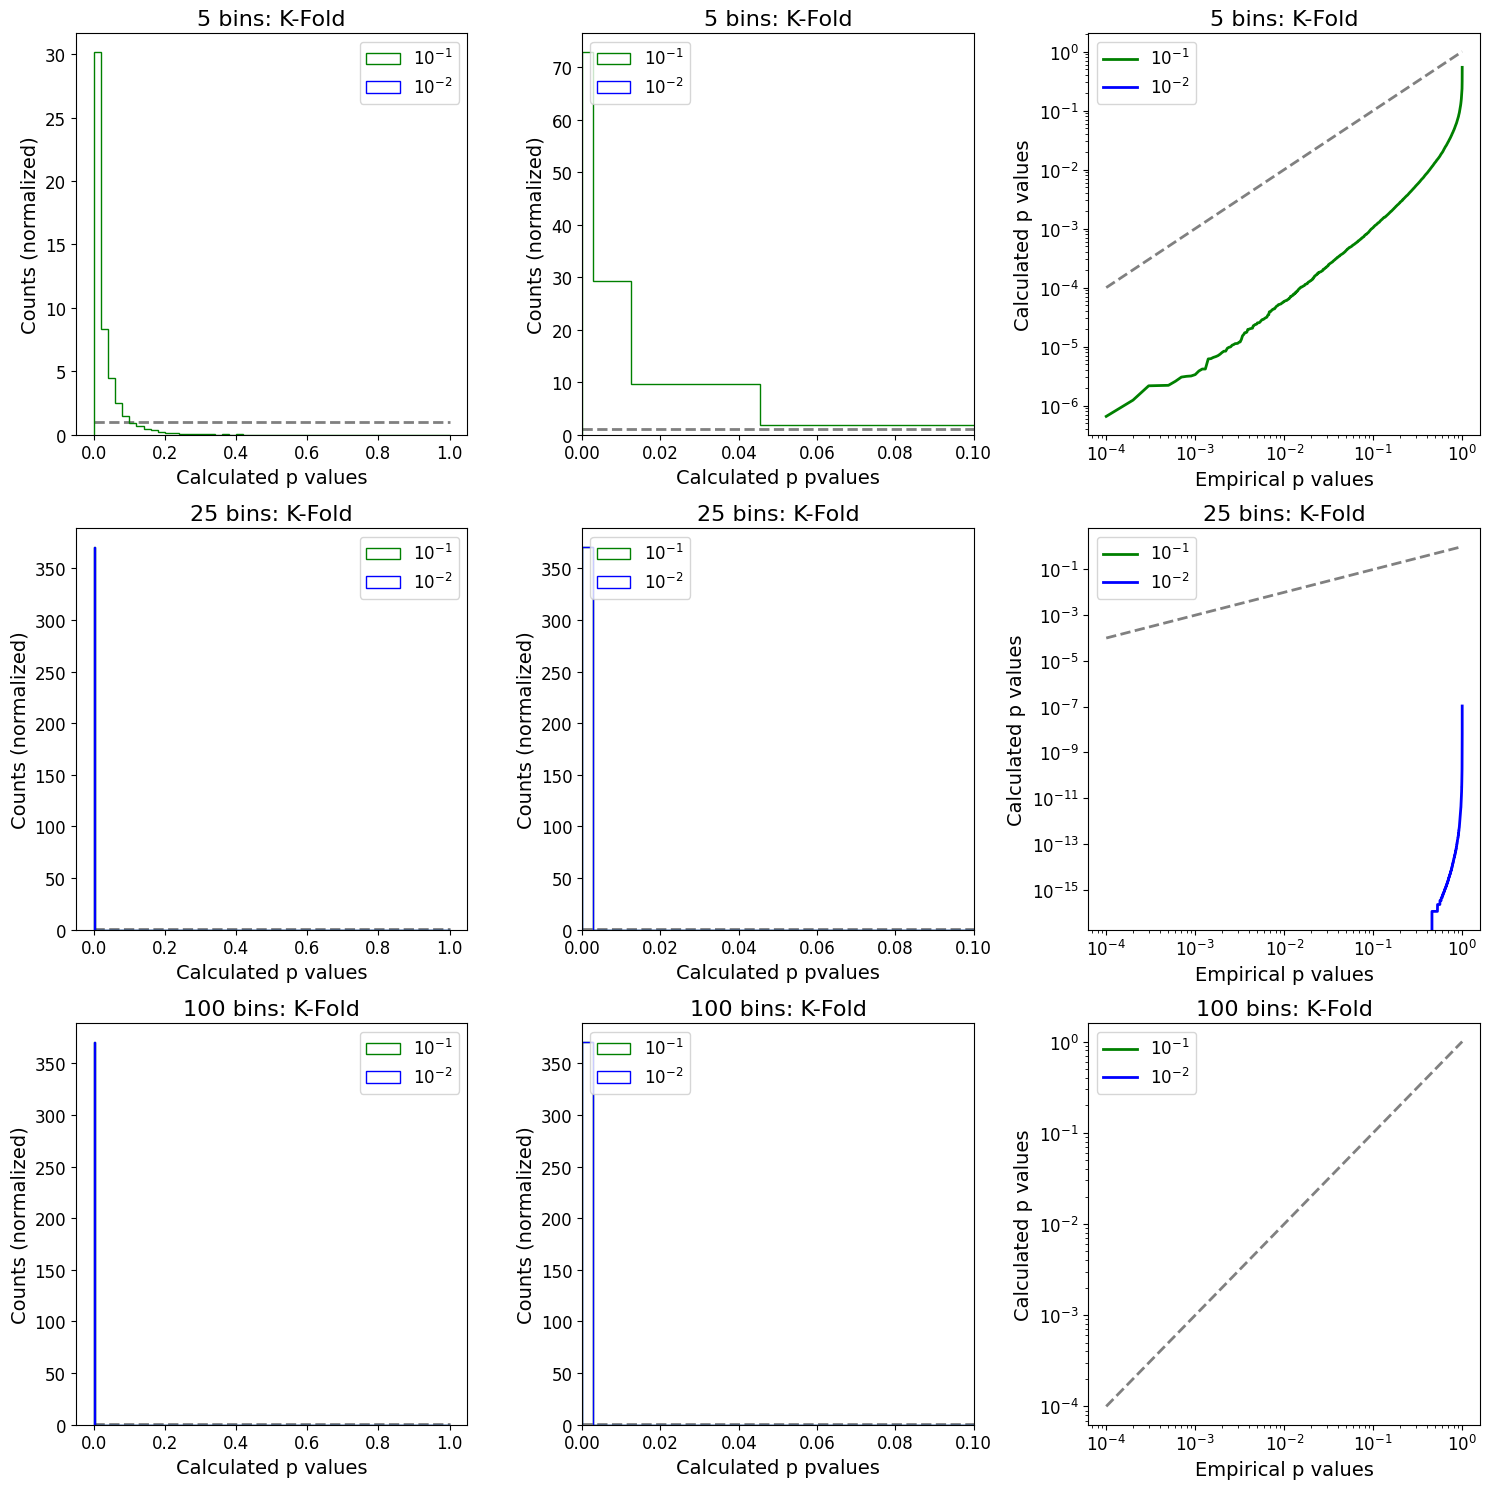

In [35]:
p_5 = np.load(directory+"bins_5/"+"p_kfold.npy", allow_pickle=True)
p_25 = np.load(directory+"bins_25/"+"p_kfold.npy", allow_pickle=True)
p_100 = np.load(directory+"bins_100/"+"p_kfold.npy", allow_pickle=True)
#p_gaussian = np.load(directory+"p_kfold_test_gaussian.npy", allow_pickle=True)
#p_noearly = np.load(directory+"p_values_kfolds_noearlystopping.npy", allow_pickle=True)

fig, ax = plt.subplots(3,3, figsize=(15,15))
bins_plot=np.linspace(0,1,51)

for i in range(3):
    ax[i,0].set_xlabel("Calculated p values")
    ax[i,0].set_ylabel("Counts (normalized)")
    ax[i,0].plot([0,1],[1,1], linestyle="dashed", color="grey")

    ax[i,1].set_xlabel("Calculated p pvalues")
    ax[i,1].set_ylabel("Counts (normalized)")
    ax[i,1].plot([0,1],[1,1], linestyle="dashed", color="grey")

    ax[i,2].set_xlabel("Empirical p values")
    ax[i,2].set_ylabel("Calculated p values")
    ax[i,2].set_xscale("log")
    ax[i,2].set_yscale("log")
    ax[i,2].plot([1e-4, 1], [1e-4, 1], color="grey", linestyle="dashed")

plot_histogram(ax[0,0], p_5, bins_plot)

ax[0,0].legend(loc="upper right")
ax[0,0].set_title("5 bins: K-Fold")
#ax[1,0].set_ylim(0,2)

bins_plot=[0, 2-2*stats.norm.cdf(3), 2-2*stats.norm.cdf(2.5), 2-2*stats.norm.cdf(2), 2-2*stats.norm.cdf(1.5), 2-2*stats.norm.cdf(1), 1]
plot_histogram(ax[0,1], p_5, bins_plot)
ax[0,1].legend(loc="upper left")
ax[0,1].set_title("5 bins: K-Fold")
ax[0,1].set_xlim(0,0.1)

plot_array(ax[0,2], p_5)
ax[0,2].legend(loc="upper left")
ax[0,2].set_title("5 bins: K-Fold")

plot_histogram(ax[1,0], p_25, bins_plot)
ax[1,0].legend(loc="upper right")
ax[1,0].set_title("25 bins: K-Fold")
#ax[1,0].set_ylim(0,2)

bins_plot=[0, 2-2*stats.norm.cdf(3), 2-2*stats.norm.cdf(2.5), 2-2*stats.norm.cdf(2), 2-2*stats.norm.cdf(1.5), 2-2*stats.norm.cdf(1), 1]
plot_histogram(ax[1,1], p_25, bins_plot)
ax[1,1].legend(loc="upper left")
ax[1,1].set_title("25 bins: K-Fold")
ax[1,1].set_xlim(0,0.1)

plot_array(ax[1,2], p_25)
ax[1,2].legend(loc="upper left")
ax[1,2].set_title("25 bins: K-Fold")


plot_histogram(ax[2,0], p_100, bins_plot)
ax[2,0].legend(loc="upper right")
ax[2,0].set_title("100 bins: K-Fold")
#ax[1,0].set_ylim(0,2)

bins_plot=[0, 2-2*stats.norm.cdf(3), 2-2*stats.norm.cdf(2.5), 2-2*stats.norm.cdf(2), 2-2*stats.norm.cdf(1.5), 2-2*stats.norm.cdf(1), 1]
plot_histogram(ax[2,1], p_100, bins_plot)
ax[2,1].legend(loc="upper left")
ax[2,1].set_title("100 bins: K-Fold")
ax[2,1].set_xlim(0,0.1)

plot_array(ax[2,2], p_100)
ax[2,2].legend(loc="upper left")
ax[2,2].set_title("100 bins: K-Fold")


fig.tight_layout()
fig.savefig("plots/NP_kfolds.pdf")